In [ ]:
%reset

# PCA with Z-Scores

In [14]:
import os
os.chdir('/Users/ltran/Documents/TrueData29/CPC_ML_tutorial/')

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import random

from scipy.stats import fisher_exact
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d
from sklearn.model_selection import train_test_split
# Set data directory
data_dir = '/Users/ltran/Documents/Data/'

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
# Set working directory
root_dir = '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/'
out_dir = os.path.join(root_dir,'models','test')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

In [15]:
def brain_maps(X):
    CT_d_fsa5 = parcel_to_surface(X, 'aparc_fsa5')
    plot_cortical(array_name=CT_d_fsa5, surface_name="fsa5", size=(800, 400),
                  cmap='RdBu_r', color_bar=True, color_range=(-abs(X).max(), abs(X).max()))

# Load train and test sets

In [21]:
coef = pd.read_csv(os.path.join(data_dir, 'Outputs/coef_asd_td.csv'))

In [22]:
coef.loc[coef['pval'] < 0.05, 'sign'] = 'Pval < 0.05'
coef.loc[coef['pval'] > 0.05, 'sign'] = 'Pval > 0.05'
coef.loc[coef['adj_p'] < 1, 'sign'] = 'Adj-pval < 1'

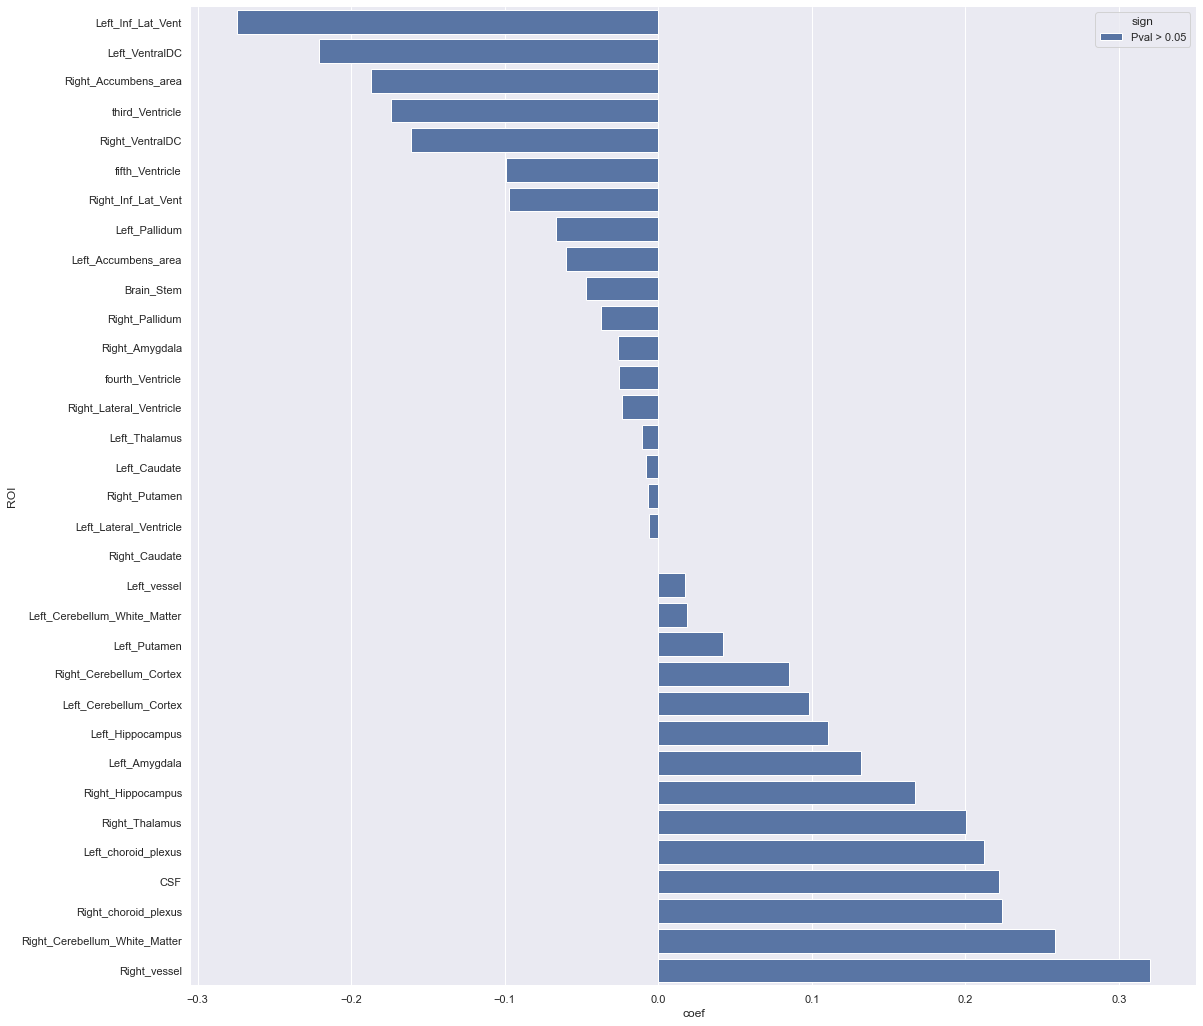

In [24]:
sns.set(rc={'figure.figsize':(18,18)})
sns.barplot(data=coef.sort_values(by = 'coef'), x="coef", y="ROI", hue='sign',
           orient='h')
sns.despine(left = True, bottom = True)
# plt.xticks(rotation=90)
plt.show()



# Import Z-Scores

In [16]:
Z_tca = pd.read_csv(os.path.join(data_dir, 'Outputs/Z_tca.csv'))

In [17]:
Z_asd = pd.read_csv(os.path.join(data_dir, 'Outputs/Z_tsa.csv'))

In [83]:
Z_aims = pd.read_csv(os.path.join(data_dir, 'Outputs/Z_aims.csv'))

In [55]:
Z_tca = Z_tca[Z_tca.sex == 2]
Z_asd = Z_asd[Z_asd.sex == 2]
# Z_aims = Z_aims[Z_aims.sex == 2]

In [9]:
thick = [col for col in Z_tca.columns if 'Z_predict' in col]
# thick.remove('lh_MeanThickness_thickness_Z_predict')
# thick.remove('rh_MeanThickness_thickness_Z_predict')
len(thick)

68

In [11]:
df = Z_tca

In [12]:
df.groupby('ASD').size()

ASD
No          28
Relative    11
TCA          6
TCA_ac      39
TCA_pr      47
dtype: int64

## Plot Z-Scores

In [3]:
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

In [4]:
sns.set_style('darkgrid')
for i in thick:
    print(i)
    sns.scatterplot(data = df, y = i, x = 'age_at_scan', hue = 'ASD')
    plt.show()

NameError: name 'thick' is not defined

## PCA

In [91]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from scipy import stats

Explained Variance [25.00188704 12.32669198]


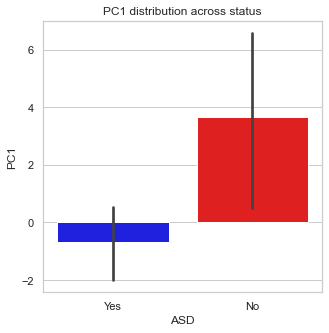

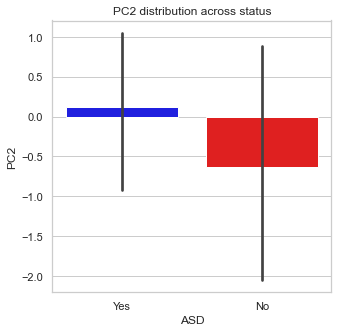

In [92]:

pca = PCA(n_components=2)
components = pca.fit_transform(df[thick])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df.ASD.replace({'No' : 'TD', 'Yes': 'Autism'}), 
                labels = {0 : pca.explained_variance_[0], 1 : pca.explained_variance_[1]})

print('Explained Variance', pca.explained_variance_)
fig.show()
sns.set(rc={'figure.figsize':(5,5)})

df_pc1 = pd.DataFrame(components).join(df.ASD.reset_index(drop = True)).rename(columns = {0 : 'PC1', 1 : 'PC2'})
df_pc1_Z = df_pc1.join(df, lsuffix = '', rsuffix = '_r')
sns.set_theme(style = 'whitegrid')
sns.barplot(data = df_pc1, x = 'ASD', y = 'PC1',
           palette = ['blue', 'red']
#             , scale = 'count', inner = 'box'
           )

plt.title('PC1 distribution across status')
plt.show()
sns.set_theme(style = 'whitegrid')
sns.barplot(data = df_pc1, x = 'ASD', y = 'PC2',
           palette = ['blue', 'red']
#             , scale = 'count', inner = 'box'
           )

plt.title('PC2 distribution across status')
plt.show()

In [93]:
loadings = pd.DataFrame(loadings)

In [94]:
brain_maps(loadings[0])
brain_maps(loadings[1])

In [68]:
loading_tca = pd.DataFrame(loadings)

In [79]:
loadings_asd = pd.DataFrame(loadings)

In [69]:
new_set = [x.replace('_Z_predict', '')for x in thick]
loadings['names'] = new_set

In [70]:

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
 

SpearmanrResult(correlation=0.9536206435851433, pvalue=3.953273144071951e-36)


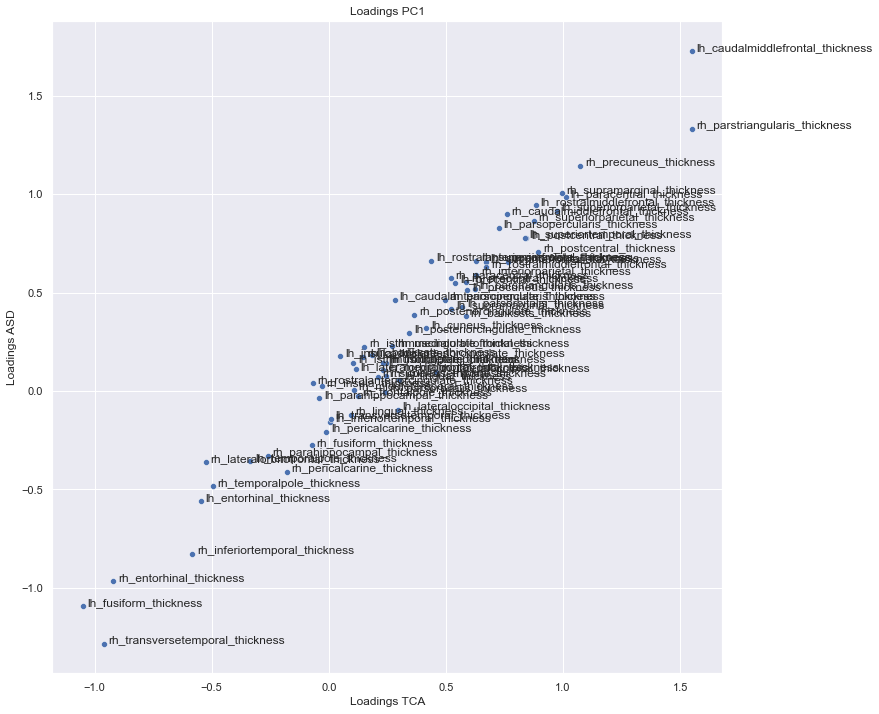

In [71]:
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.scatterplot(x = loading_tca[0], y = loadings_asd[0])
plt.title('Loadings PC1')
plt.xlabel('Loadings TCA')
plt.ylabel('Loadings ASD')
print(stats.spearmanr(loading_tca[0], loadings_asd[0]))
label_point(loading_tca[0], loadings_asd[0], loadings['names'], plt.gca())

SpearmanrResult(correlation=0.8572355613238155, pvalue=1.0720607667192045e-20)


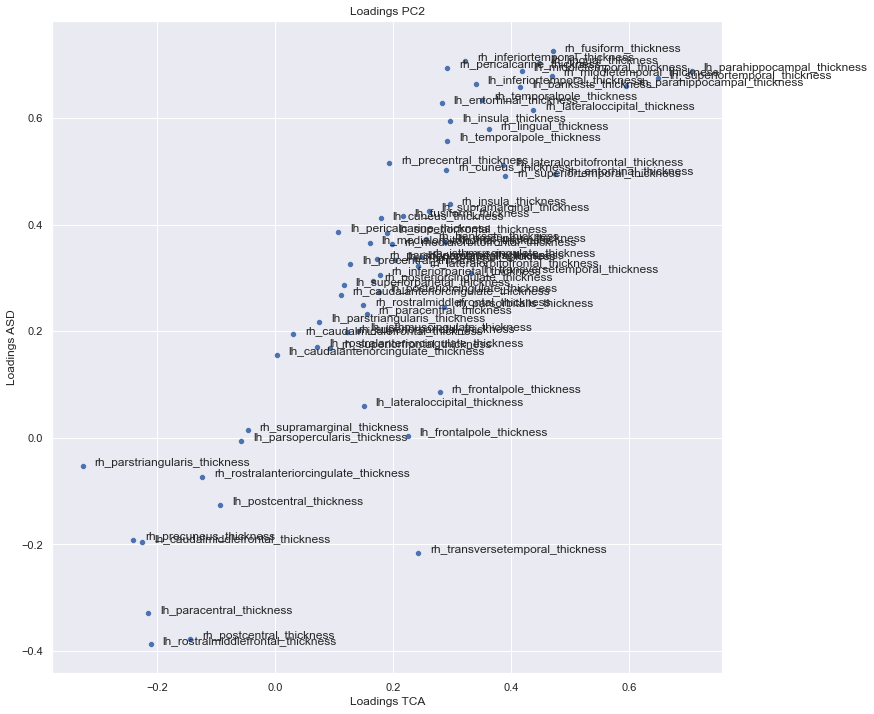

In [72]:
sns.scatterplot(x = loading_tca[1], y = loadings_asd[1])
plt.title('Loadings PC2')
plt.xlabel('Loadings TCA')
plt.ylabel('Loadings ASD')
print(stats.spearmanr(loading_tca[1], loadings_asd[1]))
label_point(loading_tca[1], loadings_asd[1], loadings['names'], plt.gca())

In [375]:
df.groupby('ASD').size()

ASD
No     15
Yes    54
dtype: int64

SpearmanrResult(correlation=-0.6567164179104477, pvalue=1.1935093381773078e-09)

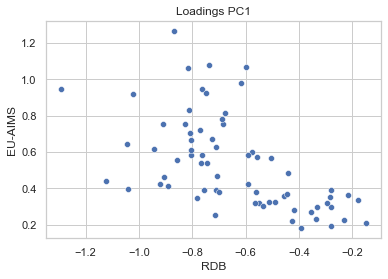

In [173]:
sns.scatterplot(x = loadRDB[0], y = loadings_aims[0])
plt.title('Loadings PC1')
plt.xlabel('RDB')
plt.ylabel('EU-AIMS')

stats.spearmanr(loadRDB[0], loadings_aims[0])


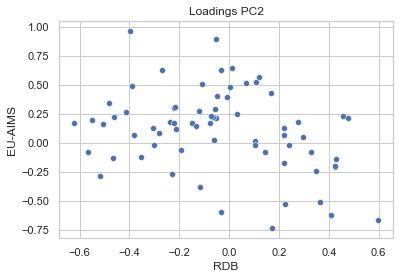

SpearmanrResult(correlation=-0.24140168721609342, pvalue=0.04734744561561437)

In [174]:
sns.scatterplot(x = loadRDB[1], y = loadings_aims[1])
plt.title('Loadings PC2')
plt.xlabel('RDB')
plt.ylabel('EU-AIMS')
plt.show()
stats.spearmanr(loadRDB[1], loadings_aims[1])

SpearmanrResult(correlation=-0.6567164179104477, pvalue=1.1935093381773078e-09)

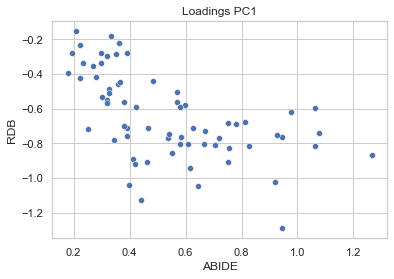

In [133]:
sns.scatterplot(x = loadAB[0], y = loadRDB[0])
plt.title('Loadings PC1')
plt.xlabel('ABIDE')
plt.ylabel('RDB')
stats.spearmanr(loadAB[0], loadRDB[0])

In [131]:
from scipy import stats
stats.spearmanr(loadAB[0], loadRDB[0])

SpearmanrResult(correlation=-0.6567164179104477, pvalue=1.1935093381773078e-09)

SpearmanrResult(correlation=-0.24140168721609342, pvalue=0.04734744561561437)

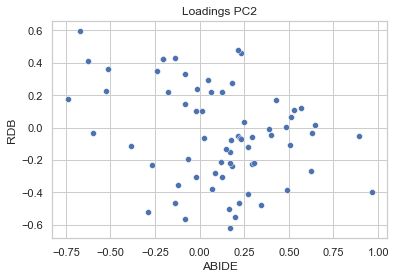

In [134]:
sns.scatterplot(x = loadAB[1], y = loadRDB[1])
plt.title('Loadings PC2')
plt.xlabel('ABIDE')
plt.ylabel('RDB')
stats.spearmanr(loadAB[1], loadRDB[1])

## Plot loadings onto brain maps

In [81]:
brain_maps(pd.DataFrame(loadings)[0])

NameError: name 'brain_maps' is not defined

In [327]:
brain_maps(pd.DataFrame(loadings)[1])